## 1. Introduction
As climate change intensifies and building energy efficiency regulations tighten, accurately estimating energy consumption during the design phase is crucial. Traditional methods can be time-consuming and costly, but machine learning offers an efficient alternative.

This project, under the University College London (UCL) IXN initiative, utilized machine learning models to predict heating and cooling loads in buildings using the Energy Efficiency dataset from the UCI Machine Learning Repository. The dataset includes 768 samples of residential buildings, with varying surface areas and dimensions.

The models assess energy efficiency based on architectural features like compactness, orientation, and glazing. Performance is evaluated using metrics such as Mean Absolute Error (MAE) and R-squared, with results visualized through heatmaps and coolmaps. This approach demonstrates the potential of machine learning to enhance early-stage building design for improved energy efficiency.

Specifically:  
* `X1`	Relative Compactness  

* `X2`	Wall Area (m\(^2\))  

* `X3`	Roof Area (m\(^2\))  

* `X4`	Overall Height (m)  

* `X5`	Orientation  

* `X6`	Glazing Area (m\(^2\)). Three types of glazing areas, which are expressed as percentages of the floor area: 10%, 25%, and 40%.  

* `X7`	Glazing Area Distribution. (1) uniform: with 25% glazing on each side, (2) north: 55% on the north side and 15% on each of the other sides, (3) east: 55% on the east side and 15% on each of the other sides, (4) south: 55% on the south side and 15% on each of the other sides, and (5) west: 55% on the west side and 15% on each of the other sides.    

* `y1`	Heating Load  (kWh/m\(^2\))

* `y2`	Cooling Load  (kWh/m\(^2\))

The goal is to use the 8 features to predict each of the 2 targets.

## 2. Exploratory Data Analysis and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

warnings.filterwarnings("ignore")
sns.set_theme()

In [2]:
# load data
data = pd.read_csv('/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/ENB2012_data.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,Y1,Y2
0,0.98,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
# rename columns to more informative names
data.columns = ['relative_compactness', 'wall_area', 'roof_area', 'overall_height', 'orientation', 
                'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

In [4]:
# check data type and whether there is missing value and 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   wall_area                  768 non-null    float64
 2   roof_area                  768 non-null    float64
 3   overall_height             768 non-null    float64
 4   orientation                768 non-null    int64  
 5   glazing_area               768 non-null    float64
 6   glazing_area_distribution  768 non-null    int64  
 7   heating_load               768 non-null    float64
 8   cooling_load               768 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


* There is no missing data.  
* As known from the dataset description, `orientation` and `glazing_area_distribution` should be categorical variables.

In [5]:
# check the distribution of these two variables to confirm
print(data['orientation'].value_counts())
print(data['glazing_area_distribution'].value_counts())

orientation
2    192
3    192
4    192
5    192
Name: count, dtype: int64
glazing_area_distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64


In [6]:
# change the data type to category
data['orientation'] = data['orientation'].astype('category')
data['glazing_area_distribution'] = data['glazing_area_distribution'].astype('category')

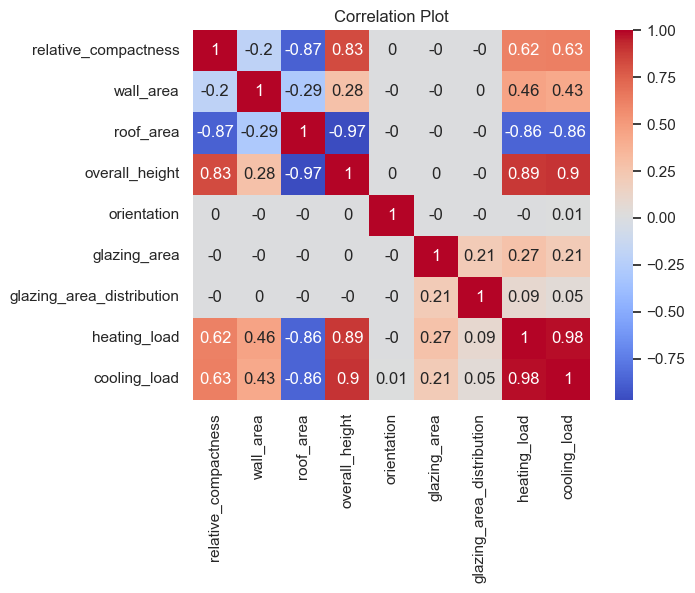

In [7]:
# check correlation between variables
corr = data.corr().round(2)
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

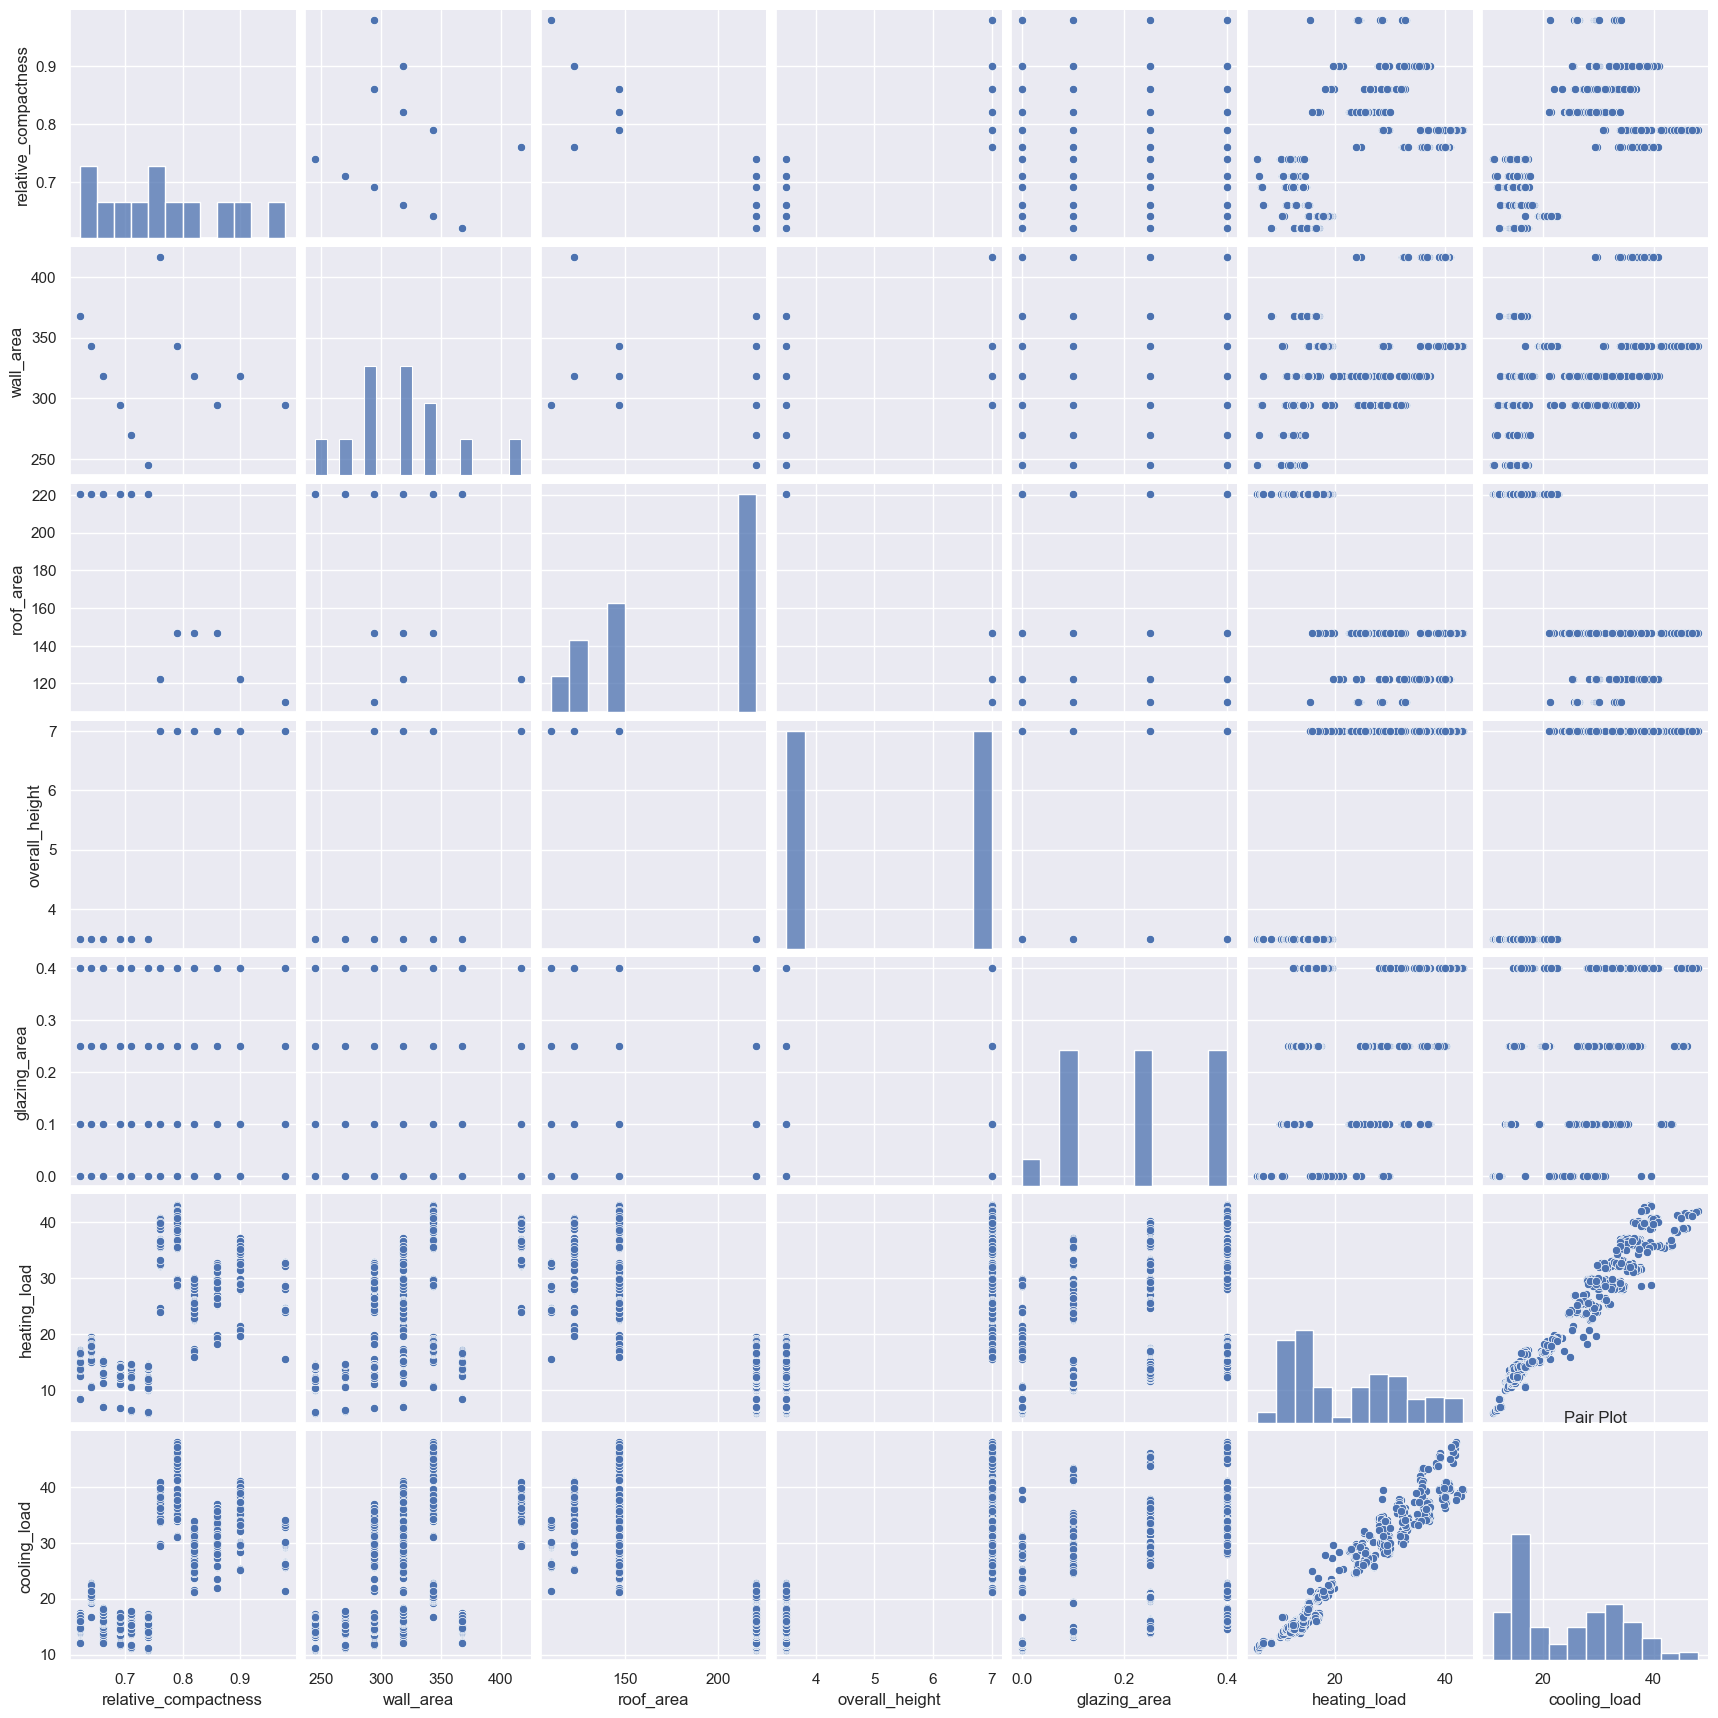

In [8]:
# check the distribution and relationship between variables
sns.pairplot(data)
plt.title('Pair Plot')
plt.show()

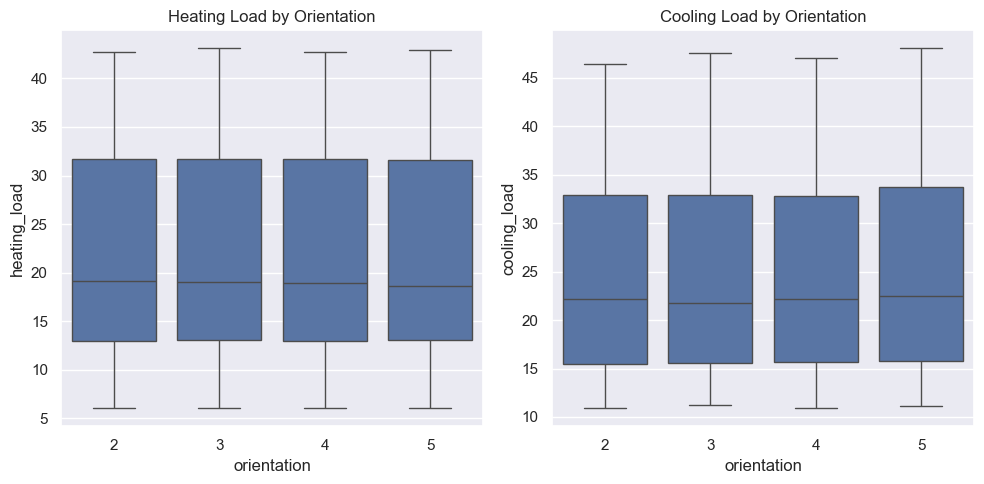

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether orientation has an impact on heating_load
sns.boxplot(data=data, x='orientation', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Orientation')

# check whether orientation has an impact on cooling_load
sns.boxplot(data=data, x='orientation', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Orientation')

plt.tight_layout()
plt.show()

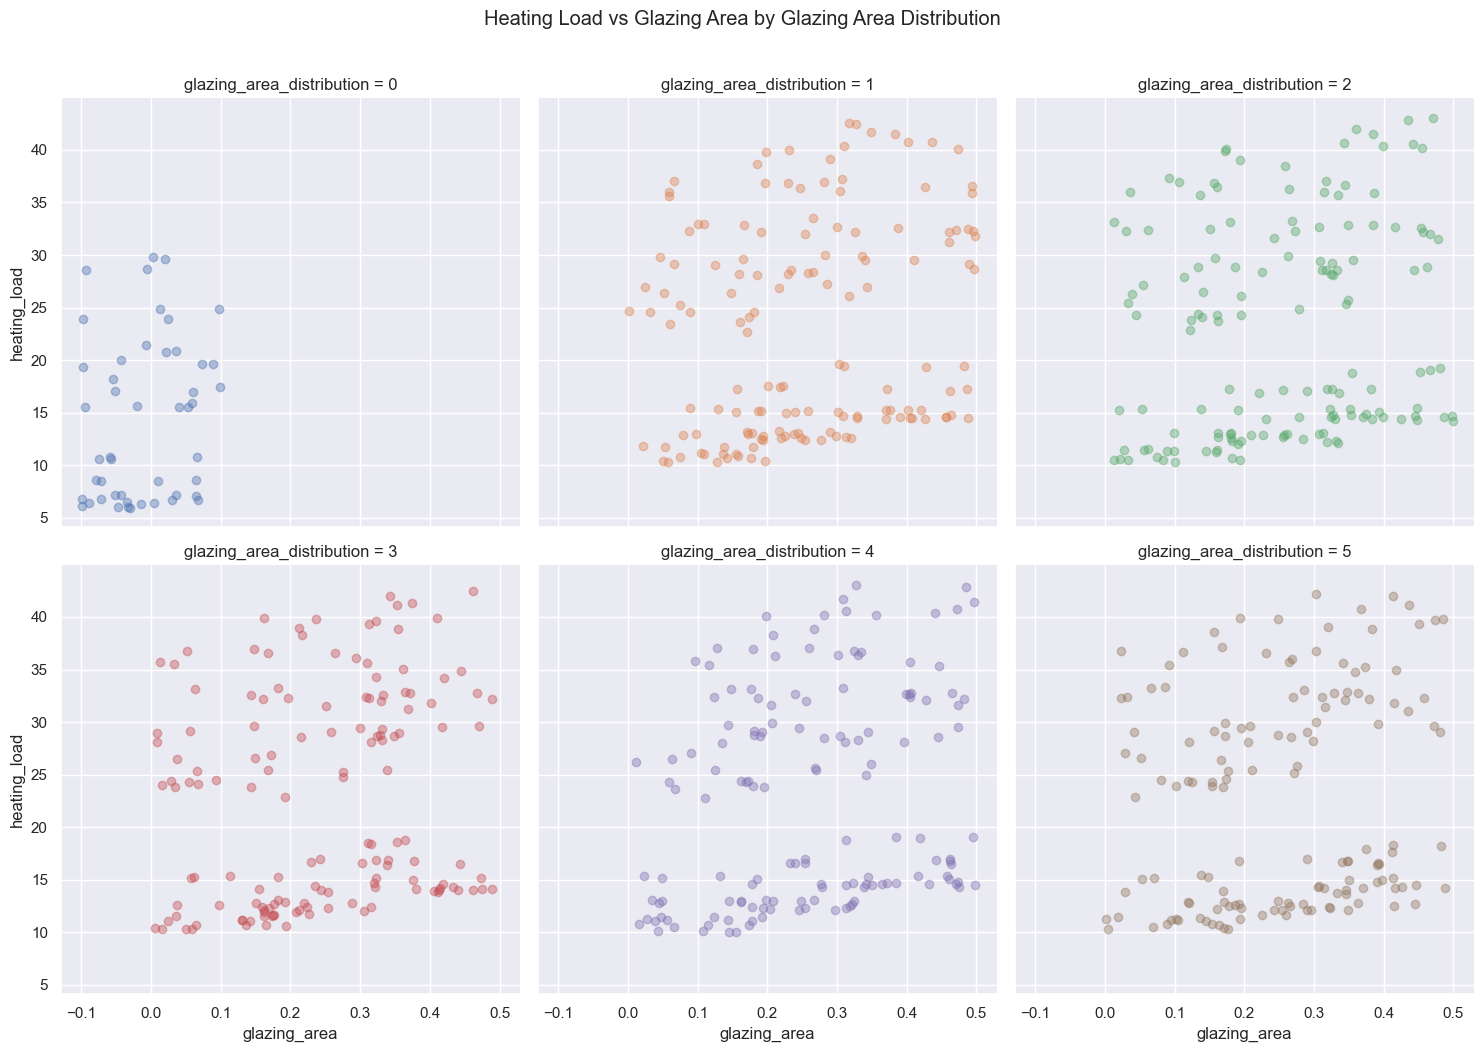

In [10]:
# check whether the glazing_area_distribution has an impact on the relationship between glazing_are and heating_load
lmplot = sns.lmplot(data=data, x='glazing_area', y='heating_load', hue='glazing_area_distribution', 
           fit_reg=False, scatter_kws={'alpha':0.4}, x_jitter=0.1, y_jitter=0.1,
           col='glazing_area_distribution', col_wrap=3)
lmplot.fig.suptitle('Heating Load vs Glazing Area by Glazing Area Distribution', y=1.05)
plt.show()



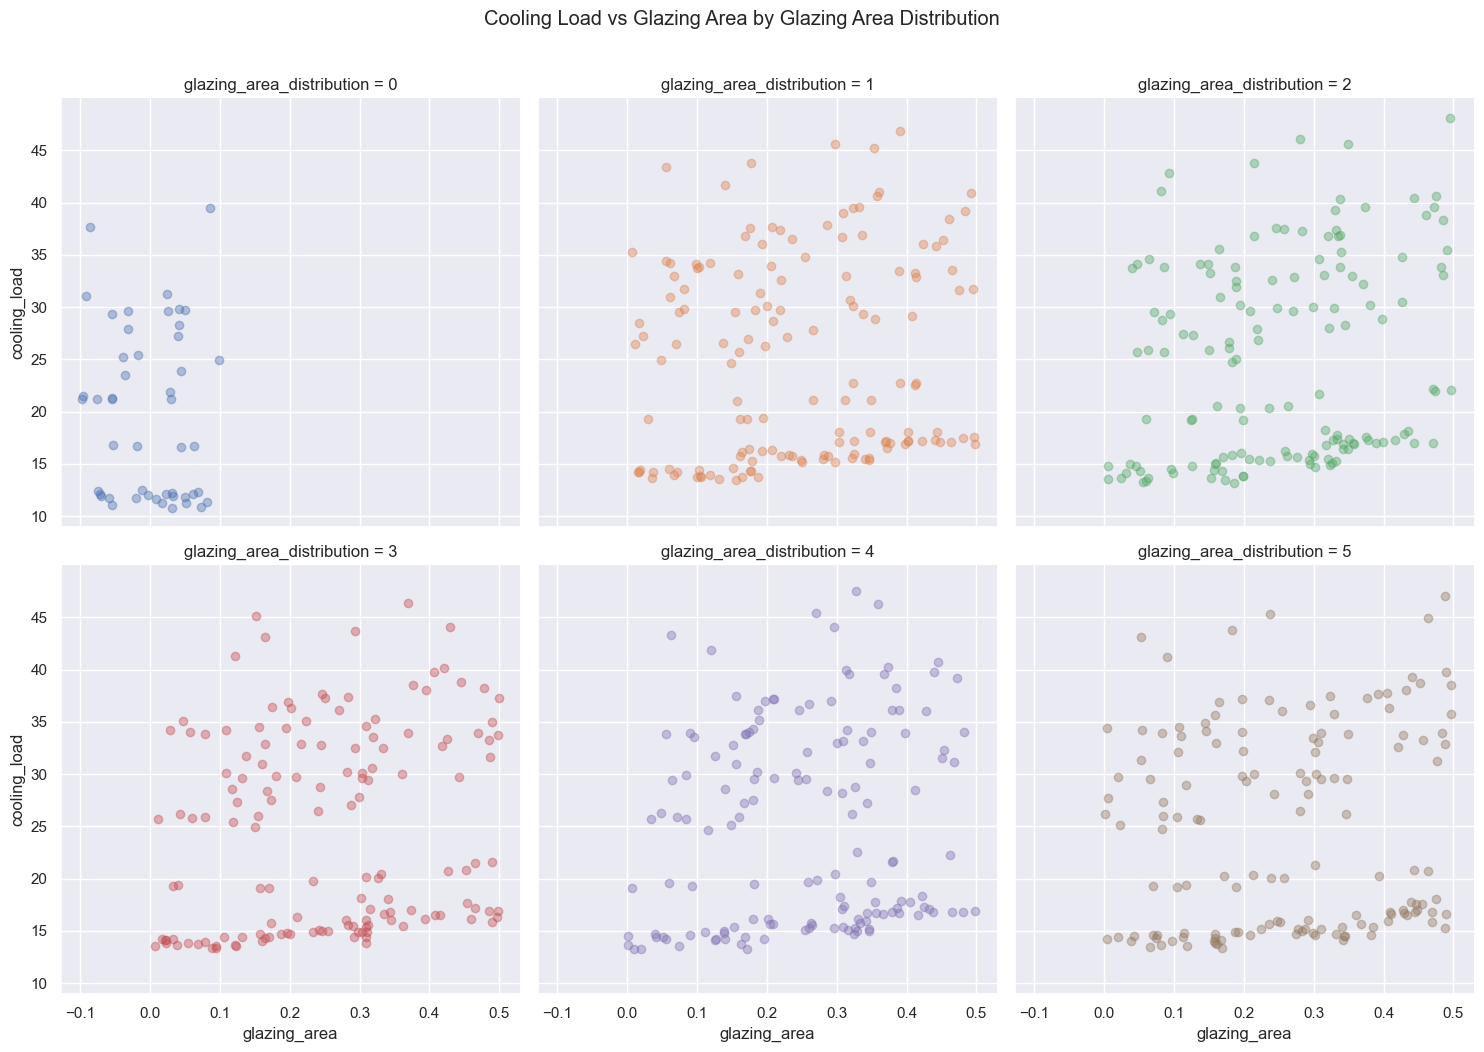

In [11]:
# check whether the glazing_area_distribution has an impact on the relationship between glazing_are and cooling_load
lmplot = sns.lmplot(data=data, x='glazing_area', y='cooling_load', hue='glazing_area_distribution', 
           fit_reg=False, scatter_kws={'alpha':0.4}, x_jitter=0.1, y_jitter=0.1,
           col='glazing_area_distribution', col_wrap=3)
lmplot.fig.suptitle('Cooling Load vs Glazing Area by Glazing Area Distribution', y=1.05)
plt.show()

* Except type 0, different types of `glazing_area_distribution` scatter similarly.

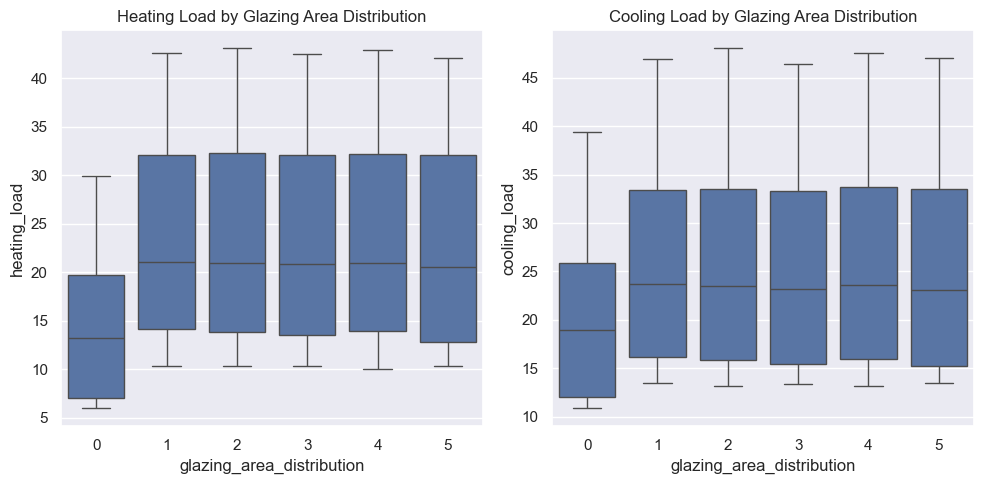

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether glazing_area_distribution has an impact on heating_load
sns.boxplot(data=data, x='glazing_area_distribution', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Glazing Area Distribution')

# check whether glazing_area_distribution has an impact on cooling_load
sns.boxplot(data=data, x='glazing_area_distribution', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Glazing Area Distribution')

plt.tight_layout()
plt.show()

* Only type 0 of `glazing_area_distribution` has an significant impact on the heating and cooling load, so I can use binarization to reduce dimensionality.

In [13]:
# change glazing_area_distribution to binary variable to reduce dimensionality
data['glazing_area_distribution'] = data['glazing_area_distribution'].replace({0:0, 1:1, 2:1, 3:1, 4:1, 5:1})
data['glazing_area_distribution'] = data['glazing_area_distribution'].astype('category')
data['glazing_area_distribution'].value_counts()

glazing_area_distribution
1    720
0     48
Name: count, dtype: int64

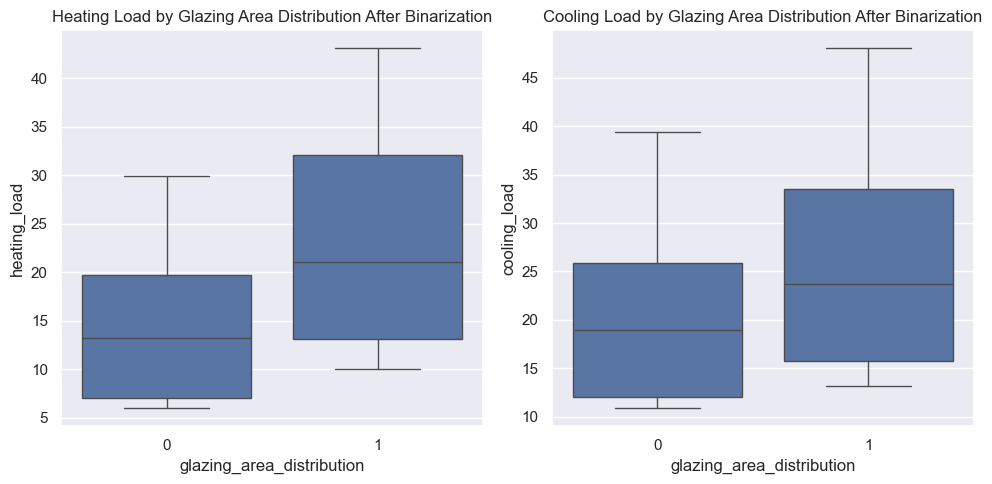

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether glazing_area_distribution has an impact on heating_load
sns.boxplot(data=data, x='glazing_area_distribution', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Glazing Area Distribution After Binarization')

# check whether glazing_area_distribution has an impact on cooling_load
sns.boxplot(data=data, x='glazing_area_distribution', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Glazing Area Distribution After Binarization')

plt.tight_layout()
plt.show()

In [15]:
# splitting the dataset into features and targets
y1 = data['heating_load']
y2 = data['cooling_load']
X = data.drop(['heating_load','cooling_load'], axis = 1)

# check features
features = list(X.columns)
features

['relative_compactness',
 'wall_area',
 'roof_area',
 'overall_height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution']

## 3. Linear Regression Model

Next, I will try the classic OLS linear regression model and see how it performs.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
seed = 1

In [17]:
# split the dataset into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.30, random_state=seed)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.30, random_state=seed)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:

# Train the model and make predictions for heating_load
lr_heating = LinearRegression()
y1_pred = lr_heating.fit(X_train, y1_train).predict(X_test)


# Train the model and make predictions for cooling_load
lr_cooling = LinearRegression()
y2_pred = lr_cooling.fit(X_train, y2_train).predict(X_test)


# calculate the adjusted R2 score
adjuted_r2_heating = 1 - (1-r2_score(y1_test, y1_pred))*(len(y1_test)-1)/(len(y1_test)-X_test.shape[1]-1)
adjuted_r2_cooling = 1 - (1-r2_score(y2_test, y2_pred))*(len(y2_test)-1)/(len(y2_test)-X_test.shape[1]-1)
print('Heating load model adjusted R2 score: \n', adjuted_r2_heating.round(4))
print('Cooling load model adjusted R2 score: \n', adjuted_r2_cooling.round(4))
print('')

# calculate the MSE
print('MSE of predicting heating load: \n', mean_squared_error(y1_test, y1_pred).round(4))
print('MSE of predicting cooling load: \n', mean_squared_error(y2_test, y2_pred).round(4))
print('')

# calculate the RMSE
print('RMSE of predicting heating load: \n', mean_squared_error(y1_test, y1_pred, squared=False).round(4))
print('RMSE of predicting cooling load: \n', mean_squared_error(y2_test, y2_pred, squared=False).round(4))
print('')

# calculate the MAE
print('MAE of predicting heating load: \n', mean_absolute_error(y1_test, y1_pred).round(4))
print('MAE of predicting cooling load: \n', mean_absolute_error(y2_test, y2_pred).round(4))

Heating load model adjusted R2 score: 
 0.8998
Cooling load model adjusted R2 score: 
 0.8606

MSE of predicting heating load: 
 9.9062
MSE of predicting cooling load: 
 12.3233

RMSE of predicting heating load: 
 3.1474
RMSE of predicting cooling load: 
 3.5105

MAE of predicting heating load: 
 2.3021
MAE of predicting cooling load: 
 2.5153


#### Interpretation of the Prediction Results

* The adjusted R squared of the heating load model and the cooling load model are 0.9003 and 0.8623 respectively, indicating that the model can explain 90.03% and 86.23% of the differences in the energy efficiency of different buildings, respectively. The models show good fits to the data and could be useful in predicting the energy efficiency based on the 6 metrics of a residential building.  

* The MAE(Mean Absolute Error) of the fitted models are 2.3002 and 2.4978 respectively, meaning that the predicted values of energy efficiency would deviate from the actual values by an average of 2.3002 and 2.4978 units respectively. This metric shows the expected error when making predictions using the fitted models and the 6 features, and allows us to determine if the error is acceptable in the use case.  

* The MSE(Mean Squared Error) is 9.8933 and 12.2353 respectively. This metric is larger than the MAE because it penalizes large errors by squaring each error. It could be useful when comparing the performance of different models because MSE can show the instability of the prediction performance of different models.  

* The RMSE(Root Mean Squared Error) is 3.1454 and 3.4979 respectively. This metric takes the square root of the mean squared error to make the unit of the RMSE the same as the unit of the target variable, which is energy efficiency in this case, so it could be better interpreted in the context of the use case and by people without statistical background. It's still larger than MAE because it penalizes large errors.

After evaluating the performance of the model, I check the feature importance to see which features of a residential building contribute most to the energy efficiency.

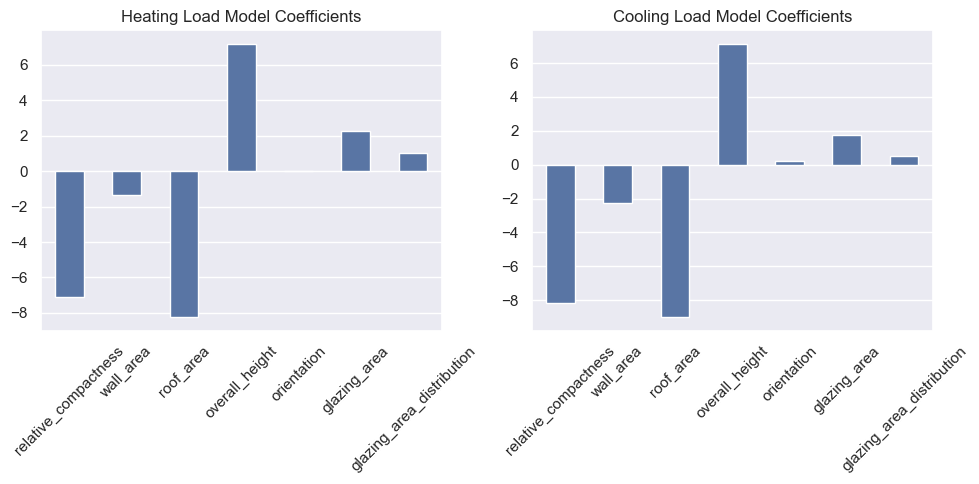

In [19]:
# plot the coefficients of features
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=features, y=lr_heating.coef_, width=0.5, ax=axes[0])
axes[0].set_title('Heating Load Model Coefficients')
axes[0].set_xticklabels(labels=features, rotation=45)

sns.barplot(x=features, y=lr_cooling.coef_, width=0.5, ax=axes[1])
axes[1].set_title('Cooling Load Model Coefficients')
axes[1].set_xticklabels(labels=features, rotation=45)

plt.tight_layout()
plt.show()

* The `relative_compactness` and `roof_area` have significant negative impact on both heating load and cooling load.
* The `overall_height` has significant positive impact on both heating load and cooling load.
* These three features have the greatest impact on energy efficiency.

In [20]:
# check the coefficients and intercepts of the models
print('Heating load model coefficients:')
for i in range(len(features)):
    print(features[i], ':', lr_heating.coef_[i])
print('Heating load model intercept: \n', lr_heating.intercept_)
print('')

print('Cooling load model coefficients:')
for i in range(len(features)):
    print(features[i], ':', lr_cooling.coef_[i])
print('Cooling load model intercept: \n', lr_cooling.intercept_)

Heating load model coefficients:
relative_compactness : -7.096056199089214
wall_area : -1.316586655509779
roof_area : -8.237492419260391
overall_height : 7.18114294701982
orientation : 0.034103137911642545
glazing_area : 2.242966268137125
glazing_area_distribution : 1.0198897613973381
Heating load model intercept: 
 21.914413407821232

Cooling load model coefficients:
relative_compactness : -8.15708234573076
wall_area : -2.231381173746616
roof_area : -8.987894377198945
overall_height : 7.117692473258431
orientation : 0.22816925640114047
glazing_area : 1.7627150990113647
glazing_area_distribution : 0.507132052185072
Cooling load model intercept: 
 24.170484171322162


## 4. Model Selection

* The pairplot above shows that there are not much linear relationship between the features and the target variables, and the variables are not normally distributed, so a linear regression model may not be the best choice for this dataset.  
* Next, I will try different types of models to see if there is a better model for predicting energy efficiency. 
* Since the dataset only contains 768 samples, it's possible to use Leave-One-Out (LOO) as the cross-validation method.

In [21]:
from sklearn.linear_model import Ridge, Lasso   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut

In [22]:
# define various models and make a list
models = [LinearRegression(), Ridge(random_state=seed), Lasso(random_state=seed), 
          DecisionTreeRegressor(random_state=seed), RandomForestRegressor(random_state=seed), 
          GradientBoostingRegressor(random_state=seed), AdaBoostRegressor(random_state=seed), 
          KNeighborsRegressor(), SVR()]

In [23]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# define a function using leave-one-out cross validation to evaluate the models
def loo_results(model, X_scaled, y):
    
    loo = LeaveOneOut()
    test_array = np.array([])
    pred_array = np.array([])
    
    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = model.fit(X_train, y_train).predict(X_test)
        test_array = np.append(test_array, y_test)
        pred_array = np.append(pred_array, y_pred)
    
    r2 = r2_score(test_array, pred_array)
    adjusted_r2 = (1 - (1-r2)*(len(test_array)-1)/(len(test_array)-X_scaled.shape[1]-1))
    mse = mean_squared_error(test_array, pred_array)
    rmse = mean_squared_error(test_array, pred_array, squared=False)
    mae = mean_absolute_error(test_array, pred_array)
    
    return adjusted_r2, mse, rmse, mae

In [25]:
# create ataframes to store the results
df_loo_heating = pd.DataFrame(columns=['Model_Heating', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])
df_loo_cooling = pd.DataFrame(columns=['Model_Cooling', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])

for model in models:
    adjuted_r2_heating, mse_heating, rmse_heating, mae_heating = loo_results(model, X_scaled, y1)
    df_loo_heating = pd.concat([df_loo_heating, 
                                pd.DataFrame([[model.__class__.__name__, 
                                               adjuted_r2_heating, mse_heating, mae_heating, rmse_heating]],
                                             columns=['Model_Heating', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])],
                                axis=0)
    adjuted_r2_cooling, mse_cooling, rmse_cooling, mae_cooling = loo_results(model, X_scaled, y2)
    df_loo_cooling = pd.concat([df_loo_cooling,
                                pd.DataFrame([[model.__class__.__name__,
                                               adjuted_r2_cooling, mse_cooling, mae_cooling, rmse_cooling]],
                                             columns=['Model_Cooling', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])],
                                axis=0)
    
# sort the results by adjusted R2
df_loo_heating = df_loo_heating.sort_values(by='LOO_Adj_R2', ascending=False).reset_index(drop=True)
df_loo_cooling = df_loo_cooling.sort_values(by='LOO_Adj_R2', ascending=False).reset_index(drop=True)

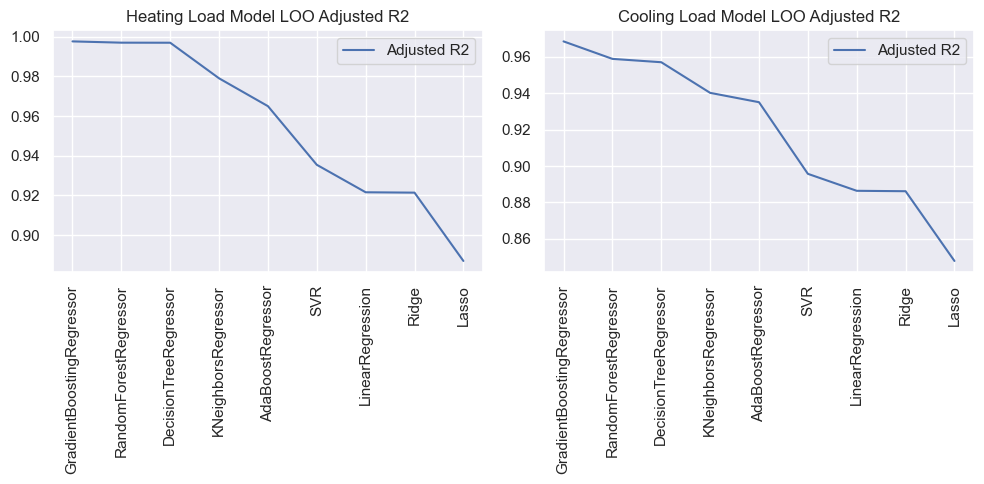

In [26]:
# plot the results of cross validation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_Adj_R2', label='Adjusted R2', ax=ax[0])
ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Heating Load Model LOO Adjusted R2')

sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_Adj_R2', label='Adjusted R2', ax=ax[1])
ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('Cooling Load Model LOO Adjusted R2')

plt.tight_layout()
plt.show()

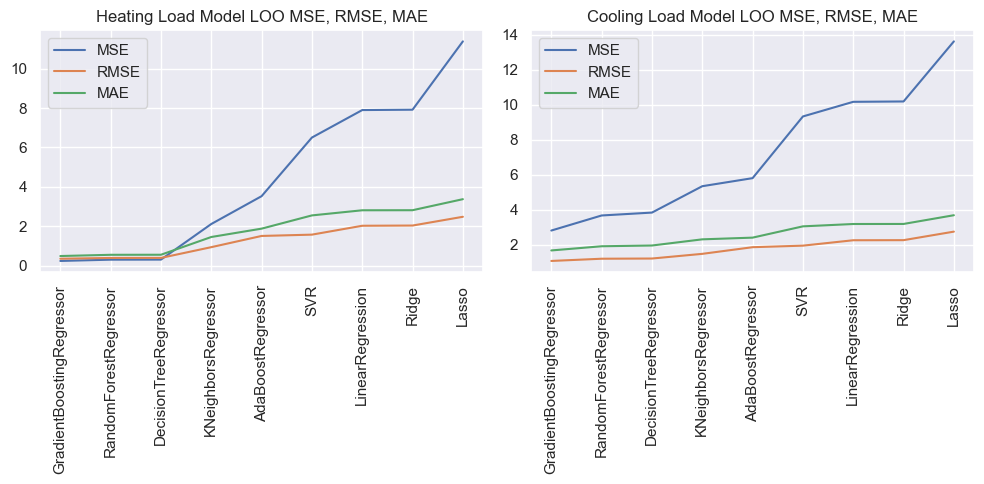

In [27]:
# plot the results of cross validation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_MSE', label='MSE', ax=ax[0])
sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_RMSE', label='RMSE', ax=ax[0])
sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_MAE', label='MAE', ax=ax[0])
ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Heating Load Model LOO MSE, RMSE, MAE')

sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_MSE', label='MSE', ax=ax[1])
sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_RMSE', label='RMSE', ax=ax[1])
sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_MAE', label='MAE', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
ax[1].set_title('Cooling Load Model LOO MSE, RMSE, MAE')

plt.tight_layout()
plt.show()

In [28]:
# check the results
print(df_loo_heating.round(4))
print('')
print(df_loo_cooling.round(4))

               Model_Heating  LOO_Adj_R2  LOO_MSE  LOO_RMSE  LOO_MAE
0  GradientBoostingRegressor      0.9976   0.2376    0.3502   0.4875
1      RandomForestRegressor      0.9970   0.3026    0.3903   0.5501
2      DecisionTreeRegressor      0.9970   0.3057    0.3921   0.5529
3        KNeighborsRegressor      0.9790   2.1134    0.9376   1.4538
4          AdaBoostRegressor      0.9650   3.5267    1.5071   1.8780
5                        SVR      0.9354   6.5038    1.5735   2.5503
6           LinearRegression      0.9216   7.8988    2.0244   2.8105
7                      Ridge      0.9214   7.9173    2.0357   2.8138
8                      Lasso      0.8870  11.3856    2.4801   3.3743

               Model_Cooling  LOO_Adj_R2  LOO_MSE  LOO_RMSE  LOO_MAE
0  GradientBoostingRegressor      0.9686   2.8163    1.0776   1.6782
1      RandomForestRegressor      0.9589   3.6776    1.2049   1.9177
2      DecisionTreeRegressor      0.9571   3.8429    1.2162   1.9603
3        KNeighborsRegressor     

## 5. Model Validation

* Comparing to the linear regression model, Gradient Boosting, Decision Tree, Random Forest and K-Nearest Neighbors have significant improvements in the cross-validation model performance.
* Next, I will test these 4 models to see which model performs best on an unseen dataset.

In [29]:
# split the data into training and testing sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=seed)

# scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
# define a function to evaluate the models using test data
def model_test(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.fit(X_train, y_train).predict(X_test)
    
    # calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = (1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    return adjusted_r2, mse, rmse, mae

In [31]:
# define the models to be tested
models_test = [ DecisionTreeRegressor(random_state=seed), RandomForestRegressor(random_state=seed),
                GradientBoostingRegressor(random_state=seed), KNeighborsRegressor()]

In [32]:
# create dataframes to store the evaluation metrics of models
df_heating_test = pd.DataFrame(columns=['Model_Heating', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])
for model in models_test:
    adjusted_r2, mse, rmse, mae = model_test(model, X_train, y1_train, X_test, y1_test)
    df_heating_test = pd.concat([df_heating_test, 
                                 pd.DataFrame([[model.__class__.__name__, adjusted_r2, mse, rmse, mae]], 
                                              columns=['Model_Heating', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])], 
                                axis=0)
df_heating_test = df_heating_test.sort_values(by='Test_Adj_R2', ascending=False).reset_index(drop=True)


df_cooling_test = pd.DataFrame(columns=['Model_Cooling', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])
for model in models_test:
    adjusted_r2, mse, rmse, mae = model_test(model, X_train, y2_train, X_test, y2_test)
    df_cooling_test = pd.concat([df_cooling_test, 
                                 pd.DataFrame([[model.__class__.__name__, adjusted_r2, mse, rmse, mae]], 
                                              columns=['Model_Cooling', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])], 
                                axis=0)
df_cooling_test = df_cooling_test.sort_values(by='Test_Adj_R2', ascending=False).reset_index(drop=True)

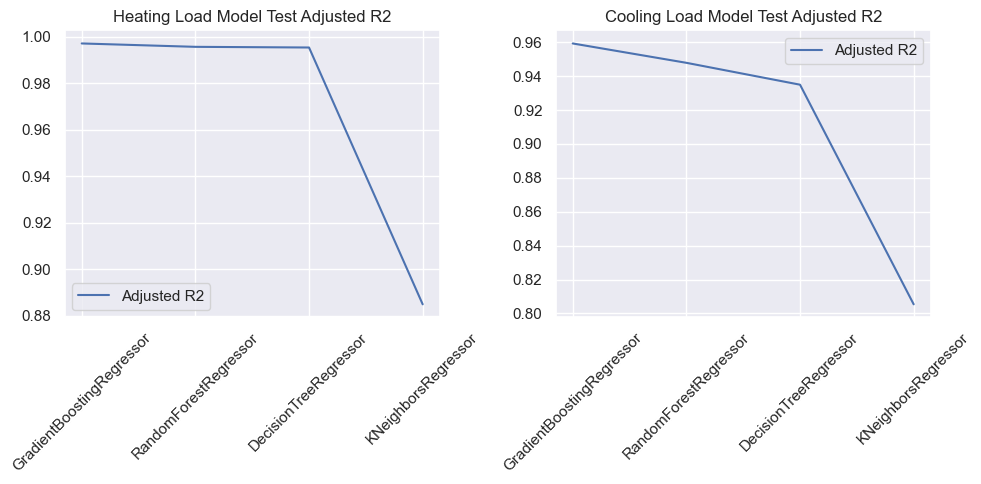

In [33]:
# plot the results of test data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_Adj_R2', label='Adjusted R2', ax=ax[0])
ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Heating Load Model Test Adjusted R2')

sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_Adj_R2', label='Adjusted R2', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
ax[1].set_title('Cooling Load Model Test Adjusted R2')

plt.tight_layout()
plt.show()

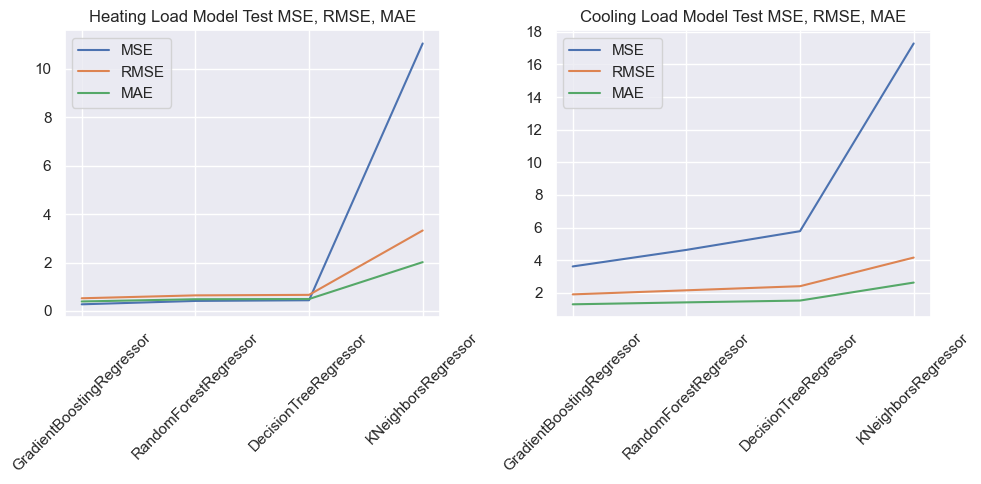

In [34]:
# plot the results of test data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_MSE', label='MSE', ax=ax[0])
sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_RMSE', label='RMSE', ax=ax[0])
sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_MAE', label='MAE', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
ax[0].set_title('Heating Load Model Test MSE, RMSE, MAE')

sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_MSE', label='MSE', ax=ax[1])
sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_RMSE', label='RMSE', ax=ax[1])
sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_MAE', label='MAE', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
ax[1].set_title('Cooling Load Model Test MSE, RMSE, MAE')

plt.tight_layout()
plt.show()

In [35]:
# check the results of test data
print(f'Heating load model test results: \n{df_heating_test.round(4)}')
print(' ')
print(f'Cooling load model test results: \n{df_cooling_test.round(4)}')

Heating load model test results: 
               Model_Heating  Test_Adj_R2  Test_MSE  Test_RMSE  Test_MAE
0  GradientBoostingRegressor       0.9971    0.2758     0.5252    0.3933
1      RandomForestRegressor       0.9957    0.4154     0.6446    0.4853
2      DecisionTreeRegressor       0.9954    0.4430     0.6656    0.4943
3        KNeighborsRegressor       0.8849   11.0415     3.3229    2.0159
 
Cooling load model test results: 
               Model_Cooling  Test_Adj_R2  Test_MSE  Test_RMSE  Test_MAE
0  GradientBoostingRegressor       0.9593    3.6146     1.9012    1.2925
1      RandomForestRegressor       0.9479    4.6294     2.1516    1.4122
2      DecisionTreeRegressor       0.9350    5.7767     2.4035    1.5225
3        KNeighborsRegressor       0.8054   17.2886     4.1580    2.6253


* On the test data set, Gradient Boosting, Decision Tree and Random Forest still have excellent performance, while K-Nearest Neighbors has worse performance compared to the cross-validation result, indicating a potential overfitting problem of the KNN model. 
* In conclusion, the tree-based models outperform the linear models on this dataset due to the non-linear relationships between the features and the target variables.

In [36]:
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


def select_and_save_best_model(results_df, model_list, metric='Test_MSE', model_type='Heating', save_dir='/path/to/save/directory', X=None, y=None):
    # Find the index of the model with the lowest metric value
    best_model_index = results_df[metric].idxmin()
    best_model_name = results_df.loc[best_model_index, f'Model_{model_type}']
    
    print(f"Best {model_type} model based on {metric}: {best_model_name}")
    
    # Retrieve the best model
    best_model = None
    for model in model_list:
        if model.__class__.__name__ == best_model_name:
            best_model = model
            break
    
    # Perform grid search if the best model is GradientBoostingRegressor
    if best_model is not None and best_model_name == 'GradientBoostingRegressor':
        # Define your hyperparameters for grid search
        params = {
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [100, 300],
            'max_depth': [3, 5],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 5]
        }
        
        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y1 if model_type == 'Heating' else y2, test_size=0.2, random_state=42)
        
        # Perform grid search
        grid_search = GridSearchCV(estimator=best_model, param_grid=params, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Retrieve the best estimator from grid search
        best_model = grid_search.best_estimator_
        print(f"Best hyperparameters found: {grid_search.best_params_}")
    
    # Train the best model on the full training data and save
    if best_model is not None:
        best_model.fit(X_train, y_train)
        
        # Save the best model to the specified directory
        model_path = os.path.join(save_dir, f'model_{model_type.lower()}_corrected.joblib')
        dump(best_model, model_path)
        print(f"Best {model_type} model ({best_model_name}) saved to {model_path}")
    else:
        print(f"No model found for {model_type}.")

# Example usage with modified function
select_and_save_best_model(results_df=df_heating_test, model_list=models, metric='Test_MSE', model_type='Heating', save_dir='/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction', X=X, y=y1)
select_and_save_best_model(results_df=df_cooling_test, model_list=models, metric='Test_MSE', model_type='Cooling', save_dir='/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction', X=X, y=y2)

Best Heating model based on Test_MSE: GradientBoostingRegressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Heating model (GradientBoostingRegressor) saved to /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_heating_corrected.joblib
Best Cooling model based on Test_MSE: GradientBoostingRegressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cooling model (GradientBoostingRegressor) saved to /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_cooling_corrected.joblib


## 6. Performance

In [41]:
print(f'Heating load average value: {np.mean(y1).round(4)}')
print(f'Heating load model prediction error: {df_heating_test.iloc[0, -1].round(4)}')
print(f'error %: {(df_heating_test.iloc[0, -1]/np.mean(y1)*100).round(4)}%')
print(' ')
print(f'Cooling load average value: {np.mean(y2).round(4)}')
print(f'Cooling load model prediction error: {df_cooling_test.iloc[0, -1].round(4)}')
print(f'error %: {(df_cooling_test.iloc[0, -1]/np.mean(y2)*100).round(4)}%')

Heating load average value: 22.3072
Heating load model prediction error: 0.3933
error %: 1.7632%
 
Cooling load average value: 24.5878
Cooling load model prediction error: 1.2925
error %: 5.2567%


* When predicting the heating load, the expected error is 0.3933 unit on average, and when predicting the cooling load, the expected error of is 1.2925 unit on average.
* These features of a residential building are more useful in predicting the heating load, with the error percentage of 1.7632%, while when in predicting the cooling load, the error percentage is 5.2567%
* Professionals with domain knowledge can determine if the error percentages are within an acceptable range.

Next, I will extract the feature importance from the tree models to see which features have the most influence on the energy efficiency.

In [38]:
# fit the models using the whole dataset
gb_heating = GradientBoostingRegressor(random_state=seed).fit(X=X, y=y1)
gb_cooling = GradientBoostingRegressor(random_state=seed).fit(X=X, y=y2)

# extract the feature importance
heating_feature_importance = pd.DataFrame(data={'Feature': X.columns, 'Importance': gb_heating.feature_importances_})
cooling_feature_importance = pd.DataFrame(data={'Feature': X.columns, 'Importance': gb_cooling.feature_importances_})

# sort the feature importance in descending order
heating_feature_importance = heating_feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)
cooling_feature_importance = cooling_feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

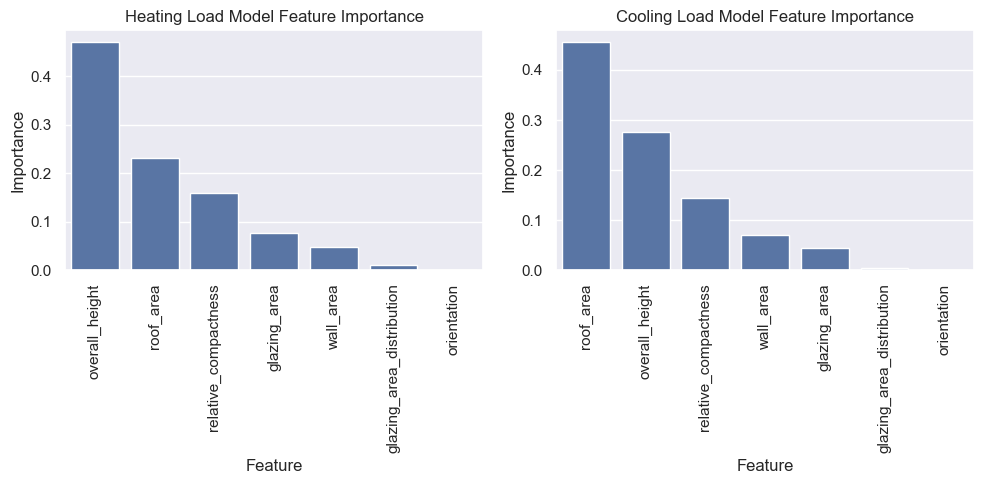

In [39]:
# plot the feature importance
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=heating_feature_importance, x='Feature', y='Importance', ax=ax[0])
ax[0].set_xticklabels(labels=heating_feature_importance['Feature'], rotation=90)
ax[0].set_title('Heating Load Model Feature Importance')

sns.barplot(data=cooling_feature_importance, x='Feature', y='Importance', ax=ax[1])
ax[1].set_xticklabels(labels=cooling_feature_importance['Feature'], rotation=90)
ax[1].set_title('Cooling Load Model Feature Importance')

plt.tight_layout()
plt.show()

* For the heating load of a residential building, roof area is the most influential factor.
* For the cooling load of a residential building, relative_compactness is the most influential factor.

In [40]:
# check the feature importance
print(f'Heating load predicting feature importance: \n{heating_feature_importance}')
print('')
print(f'Cooling load predicting feature importance: \n{cooling_feature_importance}')

Heating load predicting feature importance: 
                     Feature  Importance
0             overall_height    0.471282
1                  roof_area    0.232397
2       relative_compactness    0.159627
3               glazing_area    0.077125
4                  wall_area    0.048129
5  glazing_area_distribution    0.011368
6                orientation    0.000071

Cooling load predicting feature importance: 
                     Feature  Importance
0                  roof_area    0.456087
1             overall_height    0.276993
2       relative_compactness    0.145065
3                  wall_area    0.070573
4               glazing_area    0.045637
5  glazing_area_distribution    0.004449
6                orientation    0.001196
